## Example BAGLE fit with PyMC
The main idea for this is that I'm treating the Bagle likelihood function as a 'black box' likelihood, since it is a function that does not use PyMC's distribution format for priors/posteriors (just uses scalars instead). This code should adapt to that to allow such 'black box' functions to be used with PyMC.

- Following example: https://www.pymc.io/projects/examples/en/latest/howto/blackbox_external_likelihood_numpy.html
- SGD: https://www.pymc.io/projects/docs/en/stable/api/generated/pymc.sgd.html
- Different online learning algorithms: https://bjlkeng.io/posts/bayesian-learning-via-stochastic-gradient-langevin-dynamics-and-bayes-by-backprop/

In [1]:
import arviz as az
import IPython
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import pytensor
import pytensor.tensor as pt

print(f"Running on PyMC v{pm.__version__}")

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Running on PyMC v5.10.4


In [2]:

from bagle import model_jax as model
import traceback

In [3]:
from bagle import fake_data

In [4]:
fakeData = fake_data.fake_data1(verbose=True)
fakeData

Photometry Parameters: 
t0 =  57000.0
u0 =  -0.12536895749753274
tE =  174.69488771086006
piE_E =  0.008809500605697755
piE_N =  0.03817450262469028
b_sff =  [1.0]
mag_src =  [19.0]
Astrometry Parameters: 
mL =  57000.0
beta =  -0.12536895749753274
dL =  174.69488771086006
dS =  0.008809500605697755
xS0_E =  0.0
xS0_N =  0.0
muL_E =  0.0
muL_N =  -7.0
muS_E =  1.5
muS_N =  -0.5
muRel_E =  1.5
muRel_N =  6.5


({'target': 'NoPar',
  'phot_data': 'sim',
  'ast_data': 'sim',
  'phot_files': ['fake_data_parallax_phot1'],
  'ast_files': ['fake_data_parallax_ast1'],
  't_phot1': array([54062.625, 54063.625, 54064.625, ..., 60143.625, 60144.625,
         60145.625]),
  'mag1': array([18.90819989, 18.97846465, 18.94810036, ..., 19.04711025,
         19.0546362 , 19.07661835]),
  'mag_err1': array([0.05434933, 0.05434933, 0.05434933, ..., 0.05434949, 0.05434949,
         0.05434949]),
  't_ast1': array([54122.625, 54136.625, 54150.625, 54164.625, 54178.625, 54192.625,
         54206.625, 54220.625, 54234.625, 54487.875, 54501.875, 54515.875,
         54529.875, 54543.875, 54557.875, 54571.875, 54585.875, 54599.875,
         54853.125, 54867.125, 54881.125, 54895.125, 54909.125, 54923.125,
         54937.125, 54951.125, 54965.125, 55218.375, 55232.375, 55246.375,
         55260.375, 55274.375, 55288.375, 55302.375, 55316.375, 55330.375,
         55583.625, 55597.625, 55611.625, 55625.625, 55639.625, 

In [5]:
%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")

## Likelihood function

In [10]:
t_pho = fakeData[0]['t_phot1']
mag_obs = fakeData[0]['mag1']
mag_err_obs = fakeData[0]['mag_err1']

verbose=False
stack_trace=False
if verbose:
  print(t_pho, mag_obs, mag_err_obs)

def my_loglike(priors):
  try:
    pspl_model = model.PSPL_Phot_noPar_Param1(t0=priors[0], u0_amp=priors[1], tE=priors[2], piE_E=0.0, piE_N=0.0, b_sff=[priors[5]], mag_src=[priors[6]])
    log_likely = pspl_model.log_likely_photometry(t_pho, mag_obs, mag_err_obs, filt_index=0)
  except Exception as e:
    if verbose:
      print('t0, u0_amp, tE, piE_E, piE_N, b_sff, mag_src')
      print(priors)
      print(e)
      if stack_trace:
        tb = traceback.format_exc()
        print(tb)
          
  if np.isnan(log_likely):
    if verbose:
      print('t0, u0_amp, tE, piE_E, piE_N, b_sff, mag_src')
      print(priors)
    log_likely =  -10000.0

  return log_likely

## Creating a pytensor Op (will convert prior pymc distributions to scalars to work with our likelihood function)

In [7]:
# Define a pytensor Op for our likelihood function, used to account for difference between pm.Distributions and BAGLE scalar priors
class LogLike(pt.Op):

    """
    Specify what type of object will be passed and returned to the Op when it is
    called. In our case we will be passing it a vector of values (the parameters
    that define our model) and returning a single "scalar" value (the
    log-likelihood)
    """

    itypes = [pt.dvector]  # Expects a vector of parameter values when called
    otypes = [pt.dscalar]  # Outputs a single scalar value (the log likelihood)

    def __init__(self, loglike, mag_obs, t_obs, mag_err_obs):
        """
        Initialise the Op with various things that our log-likelihood function
        requires. Below are the things that are needed in this particular
        example.

        Parameters
        ----------
        loglike:
            The log-likelihood (or whatever) function we've defined
        mag_obs:
            The "observed" data that our log-likelihood function takes in
        t_obs:
            The dependent variable (aka 'x') that our model requires
        sigma: (mag_err_obs)
            The noise standard deviation that our function requires.
        """

        # add inputs as class attributes
        self.likelihood = loglike # Likelihood function
        self.mag_obs = mag_obs # Mag_obs
        self.t_obs = t_obs # times
        self.sigma = mag_err_obs # error bars, calculated in bagle, use estimate for testing

    def perform(self, node, inputs, outputs):
        # the method that is used when calling the Op
        (theta,) = inputs  # Priors

        # call the log-likelihood function
        logl = self.likelihood(theta)

        outputs[0][0] = np.array(logl)  # output the log-likelihood

## Model fit

In [8]:
'''Photometry Parameters: 
t0 =  57000.0
u0 =  -0.12536895749753274
tE =  174.69488771086006
piE_E =  0.008809500605697755
piE_N =  0.03817450262469028
b_sff =  [1.0]
mag_src =  [19.0]
Astrometry Parameters: 
mL =  57000.0
beta =  -0.12536895749753274
dL =  174.69488771086006
dS =  0.008809500605697755
xS0_E =  0.0
xS0_N =  0.0
muL_E =  0.0
muL_N =  -7.0
muS_E =  1.5
muS_N =  -0.5
muRel_E =  1.5
muRel_N =  6.5'''

'Photometry Parameters: \nt0 =  57000.0\nu0 =  -0.12536895749753274\ntE =  174.69488771086006\npiE_E =  0.008809500605697755\npiE_N =  0.03817450262469028\nb_sff =  [1.0]\nmag_src =  [19.0]\nAstrometry Parameters: \nmL =  57000.0\nbeta =  -0.12536895749753274\ndL =  174.69488771086006\ndS =  0.008809500605697755\nxS0_E =  0.0\nxS0_N =  0.0\nmuL_E =  0.0\nmuL_N =  -7.0\nmuS_E =  1.5\nmuS_N =  -0.5\nmuRel_E =  1.5\nmuRel_N =  6.5'

In [11]:
# create our Op (will convert prior pymc distributions to scalars to work with our likelihood function)
logl = LogLike(my_loglike, mag_obs, t_pho, mag_err_obs)

# use PyMC to sampler from log-likelihood
with pm.Model():
    # set prior distributions for the model
    t0 = pm.Uniform('t0', 55000.0, 60000.0)
    mag_src = pm.Uniform('mag_src', 16.0, 20.0)
    tE =  pm.Uniform('tE', 150.0, 250.0)
    u0_amp = pm.Uniform('u0_amp', .1, 1.0) # try .1 to 1
    piE_E = pm.Uniform('piE_E', -1.0, 1.0)
    piE_N = pm.Uniform('piE_N', -1.0, 1.0)
    b_sff = pm.Uniform('b_sff', 0.1, 1.0) # try between 0.9 1

    # convert priors to a tensor vector
    priors = pt.as_tensor_variable([
      t0,
      u0_amp,
      tE,
      piE_E,
      piE_N,
      b_sff,
      mag_src
    ])

    # use a Potential to "call" the Op and include it in the logp computation
    pm.Potential("likelihood", logl(priors))

    # approx = pm.fit(method=pm.sgd(logl(priors)), priors) # might work?

    # Use custom number of draws to replace the HMC based defaults
    idata_mh = pm.sample(1000)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Slice: [t0]
>Slice: [mag_src]
>Slice: [tE]
>Slice: [u0_amp]
>Slice: [piE_E]
>Slice: [piE_N]
>Slice: [b_sff]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 451 seconds.


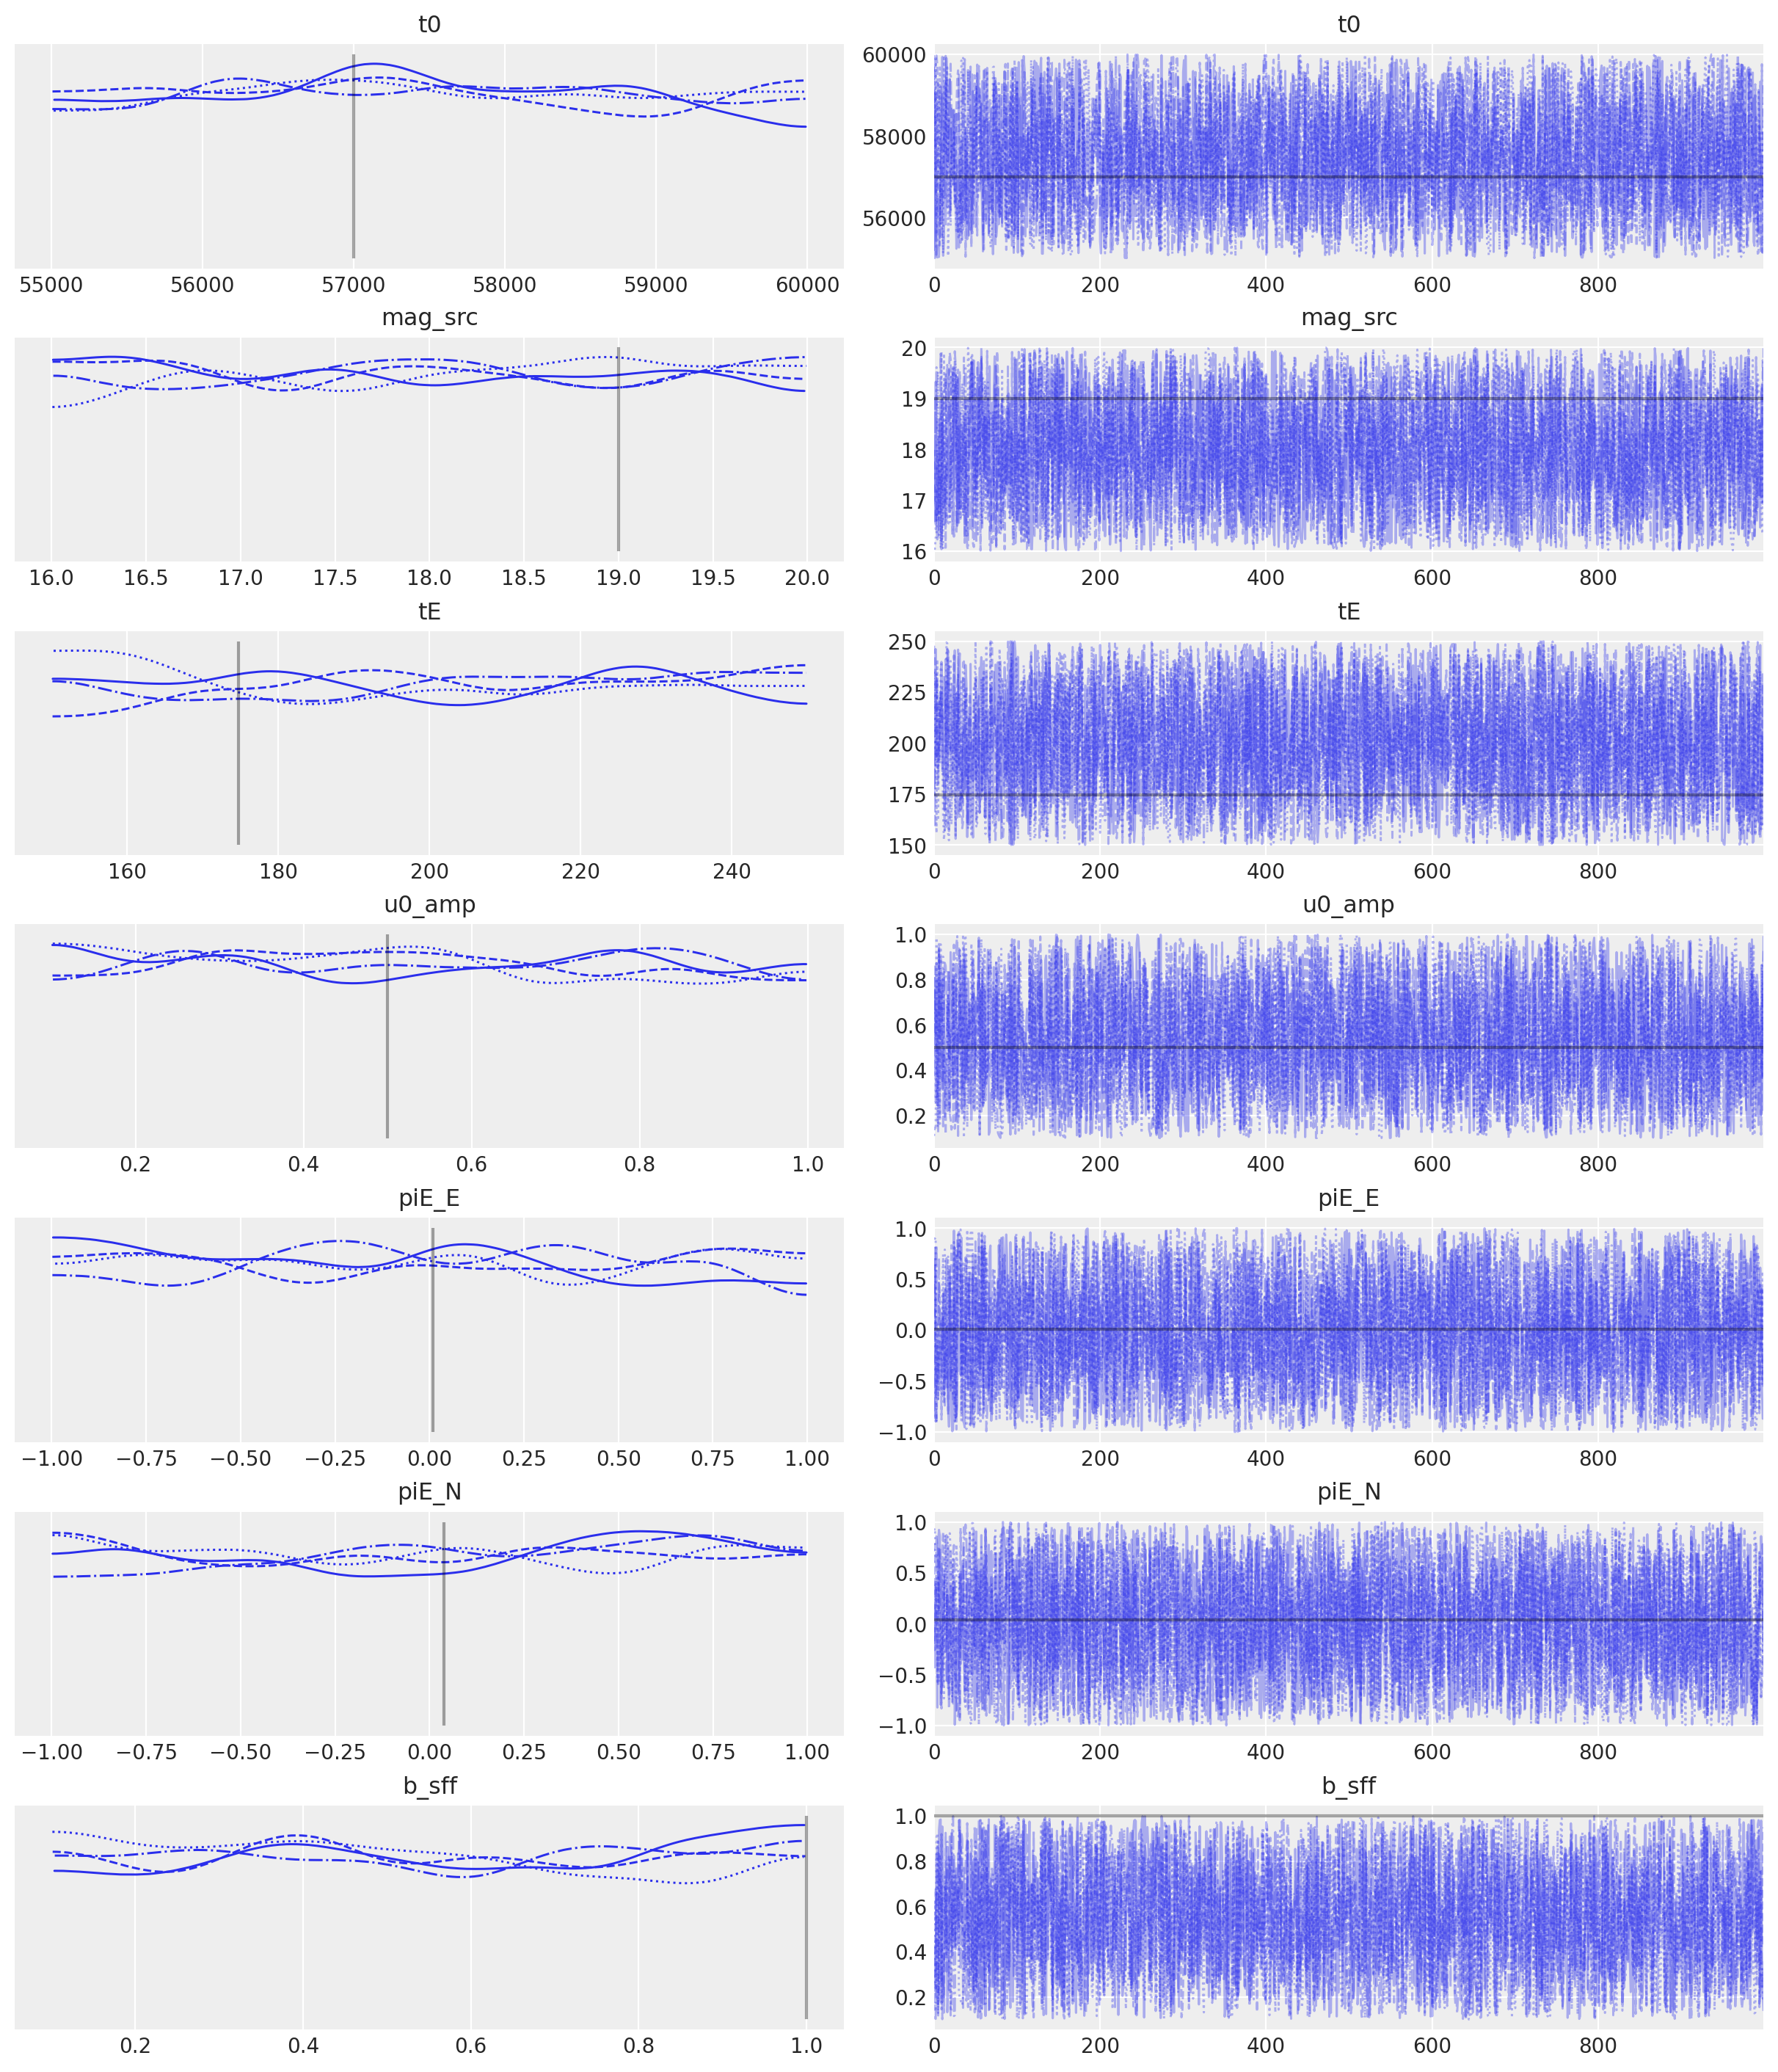

In [12]:
# plot the traces

t0_true =  57000.0
u0_true =  -0.12536895749753274
tE_true =  174.69488771086006
piE_E_true =  0.008809500605697755
piE_N_treu =  0.03817450262469028
b_sff_true =  1.0
mag_src_true = 19.0
u0_amp_true = 0.5

az.plot_trace(idata_mh, lines=[("t0", {}, t0_true), ("tE", {}, tE_true), ("piE_E", {}, piE_E_true), ("piE_N", {}, piE_N_treu), ("b_sff", {}, b_sff_true), ("mag_src", {}, mag_src_true), ("u0_amp", {}, u0_amp_true)]);

## Adding a grad function

In [106]:
def my_model(theta, t_obs):
    t0, u0_amp, tE, piE_E, piE_N, b_sff, mag_src = theta
    pspl_model_curr = model.PSPL_Phot_noPar_Param1(t0, u0_amp, tE, piE_E, piE_N, b_sff, mag_src)
    curr_data = pspl_model_curr.get_photometry(t_obs)
    return curr_data

# PyMC Example fit with grad:


In [ ]:
# define a pytensor Op for our likelihood function
class LogLikeWithGrad(pt.Op):
    itypes = [pt.dvector]  # expects a vector of parameter values when called
    otypes = [pt.dscalar]  # outputs a single scalar value (the log likelihood)

    def __init__(self, loglike, data, x, sigma):
        """
        Initialise with various things that the function requires. Below
        are the things that are needed in this particular example.

        Parameters
        ----------
        loglike:
            The log-likelihood (or whatever) function we've defined
        data:
            The "observed" data that our log-likelihood function takes in
        x:
            The dependent variable (aka 'x') that our model requires
        sigma:
            The noise standard deviation that out function requires.
        """

        # add inputs as class attributes
        self.likelihood = loglike
        self.data = data
        self.x = x
        self.sigma = sigma

        # initialise the gradient Op (below)
        self.logpgrad = LogLikeGrad(self.data, self.x, self.sigma)

    def perform(self, node, inputs, outputs):
        # the method that is used when calling the Op
        (theta,) = inputs  # this will contain my variables

        # call the log-likelihood function
        logl = self.likelihood(theta, self.x, self.data, self.sigma)

        outputs[0][0] = np.array(logl)  # output the log-likelihood

    def grad(self, inputs, g):
        # the method that calculates the gradients - it actually returns the
        # vector-Jacobian product - g[0] is a vector of parameter values
        (theta,) = inputs  # our parameters
        return [g[0] * self.logpgrad(theta)]


class LogLikeGrad(pt.Op):

    """
    This Op will be called with a vector of values and also return a vector of
    values - the gradients in each dimension.
    """

    itypes = [pt.dvector]
    otypes = [pt.dvector]

    def __init__(self, data, x, sigma):
        """
        Initialise with various things that the function requires. Below
        are the things that are needed in this particular example.

        Parameters
        ----------
        data:
            The "observed" data that our log-likelihood function takes in
        x:
            The dependent variable (aka 'x') that our model requires
        sigma:
            The noise standard deviation that out function requires.
        """

        # add inputs as class attributes
        self.data = data
        self.x = x
        self.sigma = sigma

    def perform(self, node, inputs, outputs):
        (theta,) = inputs

        # calculate gradients
        grads = normal_gradients(theta, self.x, self.data, self.sigma)

        outputs[0][0] = grads

In [ ]:
def my_model(theta, x):
    m, c = theta
    return m * x + c


def my_loglike(theta, x, data, sigma):
    model = my_model(theta, x)
    return -(0.5 / sigma**2) * np.sum((data - model) ** 2)

# set up our data
N = 10  # number of data points
sigma = 1.0  # standard deviation of noise
x = np.linspace(0.0, 9.0, N)

mtrue = 0.4  # true gradient
ctrue = 3.0  # true y-intercept

truemodel = my_model([mtrue, ctrue], x)

# make data
rng = np.random.default_rng(716743)
data = sigma * rng.normal(size=N) + truemodel

def normal_gradients(theta, x, data, sigma):
    """
    Calculate the partial derivatives of a function at a set of values. The
    derivatives are calculated using the central difference, using an iterative
    method to check that the values converge as step size decreases.

    Parameters
    ----------
    theta: array_like
        A set of values, that are passed to a function, at which to calculate
        the gradient of that function
    x, data, sigma:
        Observed variables as we have been using so far


    Returns
    -------
    grads: array_like
        An array of gradients for each non-fixed value.
    """

    grads = np.empty(2)
    aux_vect = data - my_model(theta, x)  # /(2*sigma**2)
    grads[0] = np.sum(aux_vect * x)
    grads[1] = np.sum(aux_vect)

    return grads

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


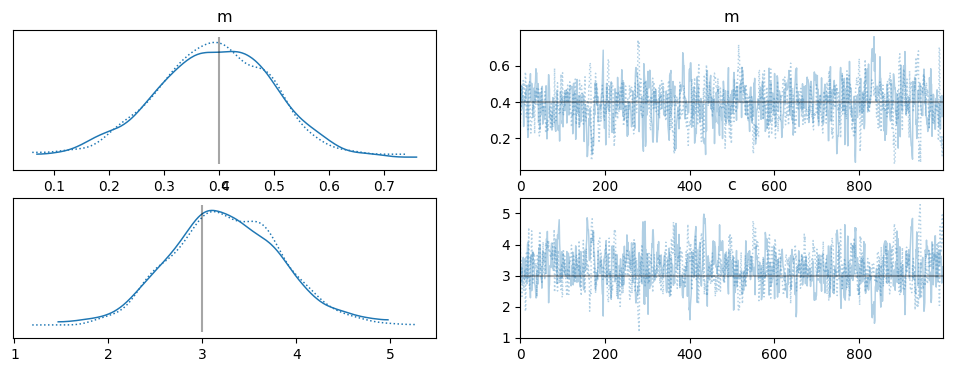

In [ ]:
# create our Op
logl = LogLikeWithGrad(my_loglike, data, x, sigma)

# use PyMC to sampler from log-likelihood
with pm.Model() as opmodel:
    # uniform priors on m and c
    m = pm.Uniform("m", lower=-10.0, upper=10.0)
    c = pm.Uniform("c", lower=-10.0, upper=10.0)

    # convert m and c to a tensor vector
    theta = pt.as_tensor_variable([m, c])

    # use a Potential
    pm.Potential("likelihood", logl(theta))

    idata_grad = pm.sample()

# plot the traces
_ = az.plot_trace(idata_grad, lines=[("m", {}, mtrue), ("c", {}, ctrue)])

In [ ]:











# other unused priors:
# 't0_prim': ('make_t0_gen', None, None),
# 'xS0_E': ('make_xS0_gen', None, None),
# 'xS0_N': ('make_xS0_gen', None, None),
# 'u0_amp_prim': ('make_gen', -1, 1),
# 'beta': ('make_gen', -2, 2),
# 'muL_E': ('make_gen', -20, 20),
# 'muL_N': ('make_gen', -20, 20),
# 'muS_E': ('make_muS_EN_gen', None, None),
# 'muS_N': ('make_muS_EN_gen', None, None),
# 'dL': ('make_gen', 1000, 8000),
# 'dS': ('make_gen', 100, 10000),
# 'dL_dS': ('make_gen', 0.01, 0.99),
# 'mag_src_pri': ('make_mag_src_gen', None, None),
# 'mag_src_sec': ('make_mag_src_gen', None, None),
# 'mag_base': ('make_mag_base_gen', None, None),
# 'piEN_piEE' : ('make_gen', -10, 10),
# 'thetaE': ('make_lognorm_gen', 0, 1),
# 'log10_thetaE': ('make_truncnorm_gen', -0.2, 0.3, -4, 4),
# 'q': ('make_gen', 0.001, 1),
# 'alpha': ('make_gen', 0, 360),
# 'phi': ('make_gen', 0, 360),
# 'sep': ('make_gen', 1e-4, 2e-2),
# 'piS': ('make_piS', None, None),
# 'add_err': ('make_gen', 0, 0.3),
# 'mult_err': ('make_gen', 1.0, 3.0),
# 'radius': ('make_gen', 1E-4, 1E-2),
# 'fratio_bin': ('make_gen', 0, 1),
